In [46]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
from analysis_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [371]:
# verdict_group_batch = "raljs5b"
# verdict_group_batch = "orz1gnj"
# verdict_group_batch = "5ot6r19"
# verdict_group_batch = "83284bs"
# verdict_group_batch = "7i08qzy"
# verdict_group_batch = "u4efe0h"
# verdict_group_batch = "l93ijir"
# verdict_group_batch = "i0rf9mt"
# verdict_group_batch = "4h2rah9"
# verdict_group_batch = "84bv6lc"
# verdict_group_batch = "irv6rnj"
# verdict_group_batch = "ofxxi38"
# verdict_group_batch = "82f280y"
# verdict_group_batch = "kttenvl"
# verdict_group_batch = "2jujbgv"
# verdict_group_batch = "82ifg57"
# verdict_group_batch = "hpmhxrw"
# verdict_group_batch = "sxn039d"
# verdict_group_batch = "e0mnuii"
# verdict_group_batch = "38wstuq"
# verdict_group_batch = "k1hq1va"
# verdict_group_batch = "yy0xnld"
# verdict_group_batch = "4iznawi"
# verdict_group_batch = "iujqr8f"
# verdict_group_batch = "gzpxjvg"
# verdict_group_batch = "sywkbw8"
# verdict_group_batch = "xe1av8b"
verdict_group_batch = "4r30ivy"


In [372]:
with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
    data = json.load(f)

verdict_ids = []
for run in data["runs"]:
    verdict_ids.append(run['verdict_run_id'])

In [373]:
data

{'group_run_id': '4r30ivy',
 'datetime': '2025-12-10T00:41:04.242275',
 'duration_seconds': 443.6021959781647,
 'runs_per_combination': 1,
 'judge_models': ['meta-llama/llama-3.1-70b-instruct'],
 'debate_run_ids': ['6ych69j'],
 'upto_turns': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'runs': [{'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': '6ych69j',
   'upto_turns': 3,
   'run_idx': 0,
   'verdict_run_id': '1fj2i05'},
  {'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': '6ych69j',
   'upto_turns': 4,
   'run_idx': 0,
   'verdict_run_id': 'juku5ze'},
  {'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': '6ych69j',
   'upto_turns': 2,
   'run_idx': 0,
   'verdict_run_id': 'qglv702'},
  {'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': '6ych69j',
   'upto_turns': 5,
   'run_idx': 0,
   'verdict_run_id': '2w6ge2u'},
  {'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': '6ych69j',
   'upto_turns': 1,
   'run_idx': 

In [374]:
all_df = prepare_df(specific_verdict_ids=verdict_ids)

checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [375]:
# per run_id (run_id_debates) count the question idxs that have has_leak_debate_checks False in all_df
leak_false_df = all_df[all_df['has_leak_debate_checks'] == True]
counts = leak_false_df.groupby('run_id_debates')['question_idx_debates'].nunique().sort_values(ascending=False)
counts


Series([], Name: question_idx_debates, dtype: int64)

In [376]:
# question_idx_save = verdicts_df['question_idx_debates'].unique()

In [377]:
verdicts_df = all_df.copy()
verdicts_df = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids)]
print(verdicts_df.shape)
# verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]
print(verdicts_df.shape)

(2117, 112)
(2117, 112)


In [378]:
# verdicts_df = verdicts_df[verdicts_df['question_idx_debates'].isin(question_idx_save)]

In [379]:
verdicts_df.shape

(2117, 112)

In [380]:
verdicts_df[['verdict_run_id_verdicts', 'config_debate_run_id_verdicts', 'config_judge_model_verdicts']].value_counts()

verdict_run_id_verdicts  config_debate_run_id_verdicts  config_judge_model_verdicts      
04b8m8o                  6ych69j                        meta-llama/llama-3.1-70b-instruct    196
2w6ge2u                  6ych69j                        meta-llama/llama-3.1-70b-instruct    196
b8gewd2                  6ych69j                        meta-llama/llama-3.1-70b-instruct    196
khnl8h5                  6ych69j                        meta-llama/llama-3.1-70b-instruct    196
krk0a9q                  6ych69j                        meta-llama/llama-3.1-70b-instruct    196
t9icnd3                  6ych69j                        meta-llama/llama-3.1-70b-instruct    195
juku5ze                  6ych69j                        meta-llama/llama-3.1-70b-instruct    192
1fj2i05                  6ych69j                        meta-llama/llama-3.1-70b-instruct    189
6pimftp                  6ych69j                        meta-llama/llama-3.1-70b-instruct    189
qglv702                  6ych69j     

In [381]:
# Showing that repetitions actually have consideralbe variability - 90% in this case - even though average verdict performance come out similar (flipping)

# set1 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == 'zv74feq']
# set2 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '4j31cg4']

# merge = set1[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']].merge(set2[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']], on=['question_idx_debates'])

# (merge['is_correct_verdict_x'] == merge['is_correct_verdict_y']).sum() / merge.shape[0]


In [387]:
# temp_df = verdicts_df
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['config_model_name_qa_judge'])
# aggregate_acc = aggregate_acc.iloc[0:-1:4]

In [388]:
aggregate_acc['gain'].sort_values(ascending=False)

0    0.054322
Name: gain, dtype: float64

(1, 15)
0.0001303394654722062


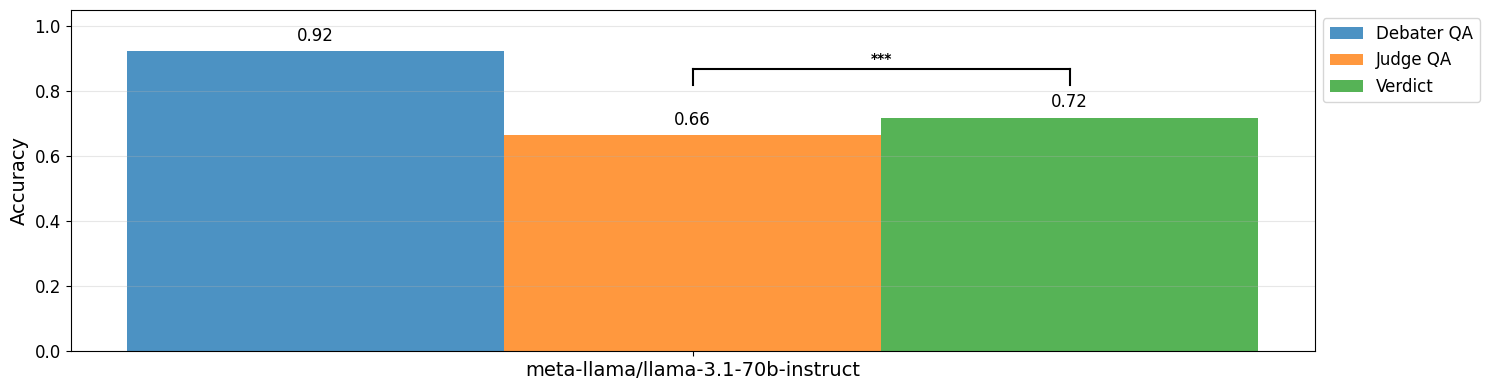

In [389]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
print(aggregate_acc.shape)
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()


In [411]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

# temp_df = temp_df[temp_df['config_debater_model_debates'] != 'meta-llama/llama-4-scout']
# temp_df = temp_df[temp_df['config_judge_model_verdicts'] == 'meta-llama/llama-3.1-8b-instruct']

# filter any cases where any of the turns in debate history have success=False
# print(temp_df.shape)
# temp_df = temp_df[temp_df['debate_history_debates'].apply(lambda x: all(turn.get('success', True) for turn in x) if isinstance(x, list) else True)]
# print(temp_df.shape)

aggregate_acc = aggregate_by_fields(temp_df, fields=['verdict_run_id_verdicts'])
aggregate_acc

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.923469,0.663265,0.806122,181,130,158,196,196,196,196,0.596939,0.549020,0.260204,0.142857,04b8m8o
1,0.920635,0.666667,0.613757,174,126,116,189,189,189,189,0.851852,-0.208333,0.253968,-0.052910,1fj2i05
2,0.923469,0.663265,0.668367,181,130,131,196,196,196,196,0.785714,0.019608,0.260204,0.005102,2w6ge2u
3,0.920635,0.661376,0.534392,174,125,101,189,189,189,189,0.920635,-0.489796,0.259259,-0.126984,6pimftp
4,0.923497,0.672131,0.693989,169,123,127,183,183,183,183,0.442623,0.086957,0.251366,0.021858,7qy5yv0
5,0.923469,0.663265,0.678571,181,130,133,196,196,196,196,0.775510,0.058824,0.260204,0.015306,b8gewd2
6,0.921875,0.666667,0.822917,177,128,158,192,192,192,192,0.473958,0.612245,0.255208,0.156250,juku5ze
7,0.923469,0.663265,0.826531,181,130,162,196,196,196,196,0.535714,0.627451,0.260204,0.163265,khnl8h5
8,0.923469,0.663265,0.709184,181,130,139,196,196,196,196,0.744898,0.176471,0.260204,0.045918,krk0a9q
9,0.925926,0.661376,0.746032,175,125,141,189,189,189,189,0.317460,0.320000,0.264550,0.084656,qglv702


In [412]:
aggregate_acc['gain'].mean(), aggregate_acc['gain'].median()

(np.float64(0.05351383101675844), np.float64(0.04591836734693877))

In [413]:
aggregate_acc['gain'].sort_values(ascending=False)

7     0.163265
6     0.156250
0     0.142857
10    0.133333
9     0.084656
8     0.045918
4     0.021858
5     0.015306
2     0.005102
1    -0.052910
3    -0.126984
Name: gain, dtype: float64

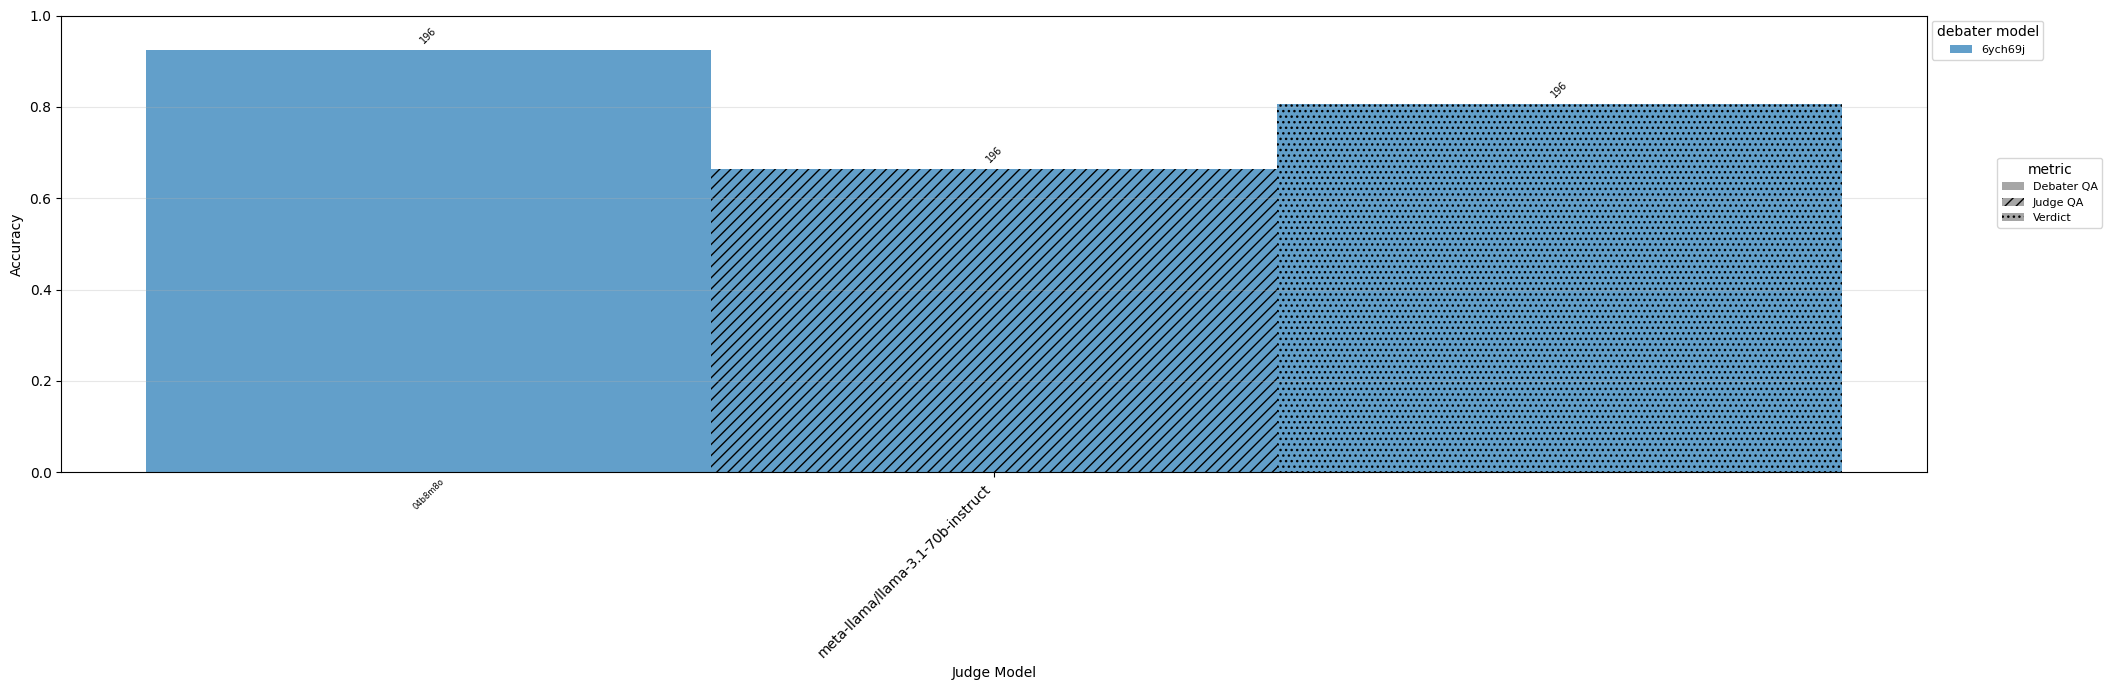

In [414]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

debate_run_id_labels = {
    'uveal9q': 'llama-3-8b-instruct',
    'z42o1e7': 'llama-3.1-8b-instruct',
    '79t2rwe': 'llama-3.1-70b-instruct',
    '2exxeqn': 'llama-3.1-405b-instruct',
    'xcmiu00': 'llama-3.3-70b-instruct',
    '3ys5csf': 'llama-4-scout',
    'pciywxv': 'llama-4-maverick'
}

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

metrics = ['debater_qa_acc', 'judge_qa_acc', 'verdict_acc']
metric_labels = ['Debater QA', 'Judge QA', 'Verdict']

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    debate_run_ids = sorted(plot_data['debate_run_id'].unique())
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    n_metrics = len(metrics)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (n_debates * n_metrics)
    
    fig, ax = plt.subplots(figsize=(25, 7))
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_debates))
    hatches = ['', '///', '...']
    
    metric_x_y_map = {
        'debater_qa_acc': ('debater_qa_n_correct', 'n_debater_qa_not_null'),
        'judge_qa_acc': ('judge_qa_n_correct', 'n_judge_qa_not_null'),
        'verdict_acc': ('verdict_n_correct', 'n_verdict_not_null')
    }
    
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
            values = []
            verdict_run_ids = []
            x_values = []
            y_values = []
            for judge_model in judge_models:
                row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
                if len(row) > 0:
                    values.append(row[metric].values[0])
                    verdict_run_ids.append(row['verdict_run_id'].values[0])
                    x_field, y_field = metric_x_y_map[metric]
                    x_values.append(int(row[x_field].values[0]))
                    y_values.append(int(row[y_field].values[0]))
                else:
                    values.append(0)
                    verdict_run_ids.append('')
                    x_values.append(0)
                    y_values.append(0)
            
            offset = (i - n_debates / 2 + 0.5) * (group_width / n_debates) + (j - n_metrics / 2 + 0.5) * width
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)}" if j == 0 else ""
            bars = ax.bar(x + offset, values, width, label=label, color=colors[i], alpha=0.7, hatch=hatches[j])
            
            for k, (bar, verdict_run_id, x_val, y_val) in enumerate(zip(bars, verdict_run_ids, x_values, y_values)):
                if verdict_run_id and j == 0:
                    ax.text(bar.get_x() + bar.get_width() / 2, -0.01, verdict_run_id,
                           ha='center', va='top', fontsize=6, rotation=45)
                if x_val > 0 or y_val > 0:
                    pct = int(x_val / y_val * 100) if y_val > 0 else 0
                    label_text = f"{y_val}"
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, label_text,
                           ha='center', va='bottom', fontsize=7, color='black', rotation=45)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    
    from matplotlib.patches import Patch
    
    legend_elements_debater = []
    for i, debate_run_id in enumerate(debate_run_ids):
        label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)}"
        legend_elements_debater.append(Patch(facecolor=colors[i], alpha=0.7, label=label))
    
    legend_elements_metric = []
    for j, metric_label in enumerate(metric_labels):
        legend_elements_metric.append(Patch(facecolor='gray', alpha=0.7, hatch=hatches[j], label=metric_label))
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    legend1 = ax.legend(handles=legend_elements_debater, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8, title='debater model')
    ax.add_artist(legend1)
    ax.legend(handles=legend_elements_metric, loc='upper left', bbox_to_anchor=(1.035, 0.7), fontsize=8, title='metric')
    
    # plt.tight_layout()
    # fig.subplots_adjust(right=0.85)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    plt.show()

In [415]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]
# temp_df = temp_df[(temp_df['config_judge_model_verdicts'] == 'meta-llama/llama-3-8b-instruct') & (temp_df['config_debater_model_debates'] == 'meta-llama/llama-3-8b-instruct')]
temp_df['is_correct_verdict'].sum(), temp_df['is_correct_qa_judge'].sum(), temp_df['is_correct_qa_debater'].sum()

(np.int64(1521), np.int64(1406), 1954)

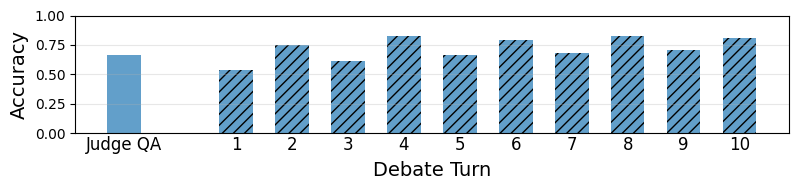

In [442]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique()])
    else:
        upto_turns_list = [None]
    
    n_bars = 1 + len(upto_turns_list)
    x = np.arange(n_bars)
    width = 0.6
    
    bar_color = plt.cm.tab10(0)
    hatches = ['', '///']
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    rows = plot_data
    judge_qa_value = rows['judge_qa_acc'].mean()
    judge_qa_n_correct = int(rows['judge_qa_n_correct'].sum())
    judge_qa_n_total = int(rows['n_judge_qa_not_null'].sum())
    
    bar_judge_qa = ax.bar(0, judge_qa_value, width, label='Judge QA', color=bar_color, alpha=0.7, hatch=hatches[0])
    ax.text(0, -0.02, 'Judge QA', ha='center', va='top', fontsize=12)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if i == 0:
            continue
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        if len(turn_data) > 1:
            raise Exception('Check why rows greater than 1')
        
        verdict_value = turn_data.iloc[0]['verdict_acc']
        verdict_n_correct = int(turn_data.iloc[0]['verdict_n_correct'])
        verdict_n_total = int(turn_data.iloc[0]['n_verdict_not_null'])
        
        bar_idx = i + 1
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bar = ax.bar(bar_idx, verdict_value, width, label=label, color=bar_color, alpha=0.7, hatch=hatches[1])
        
        turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
        ax.text(bar_idx, -0.02, turn_label, ha='center', va='top', fontsize=12)
    
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Debate Turn', fontsize=14, labelpad=20)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    # ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()


### By Category

In [395]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)
dataset_df['high_level_domain'] = dataset_df['high_level_domain'].str.lower()
verdicts_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))

In [ ]:
# mmlu_dataset = load_dataset('TIGER-Lab/MMLU-Pro')['test']

# category_map = {}
# for idx in range(len(mmlu_dataset)):
#     category_map[idx] = mmlu_dataset[idx].get('category', None)
# verdicts_df['high_level_domain'] = verdicts_df['question_idx_debates'].map(category_map)

In [396]:
# temp_df = verdicts_df.copy()

# chemistry_df = temp_df[temp_df['high_level_domain'] == 'chemistry']
# physics_df = temp_df[temp_df['high_level_domain'] == 'physics']

# chemistry_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
# physics_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

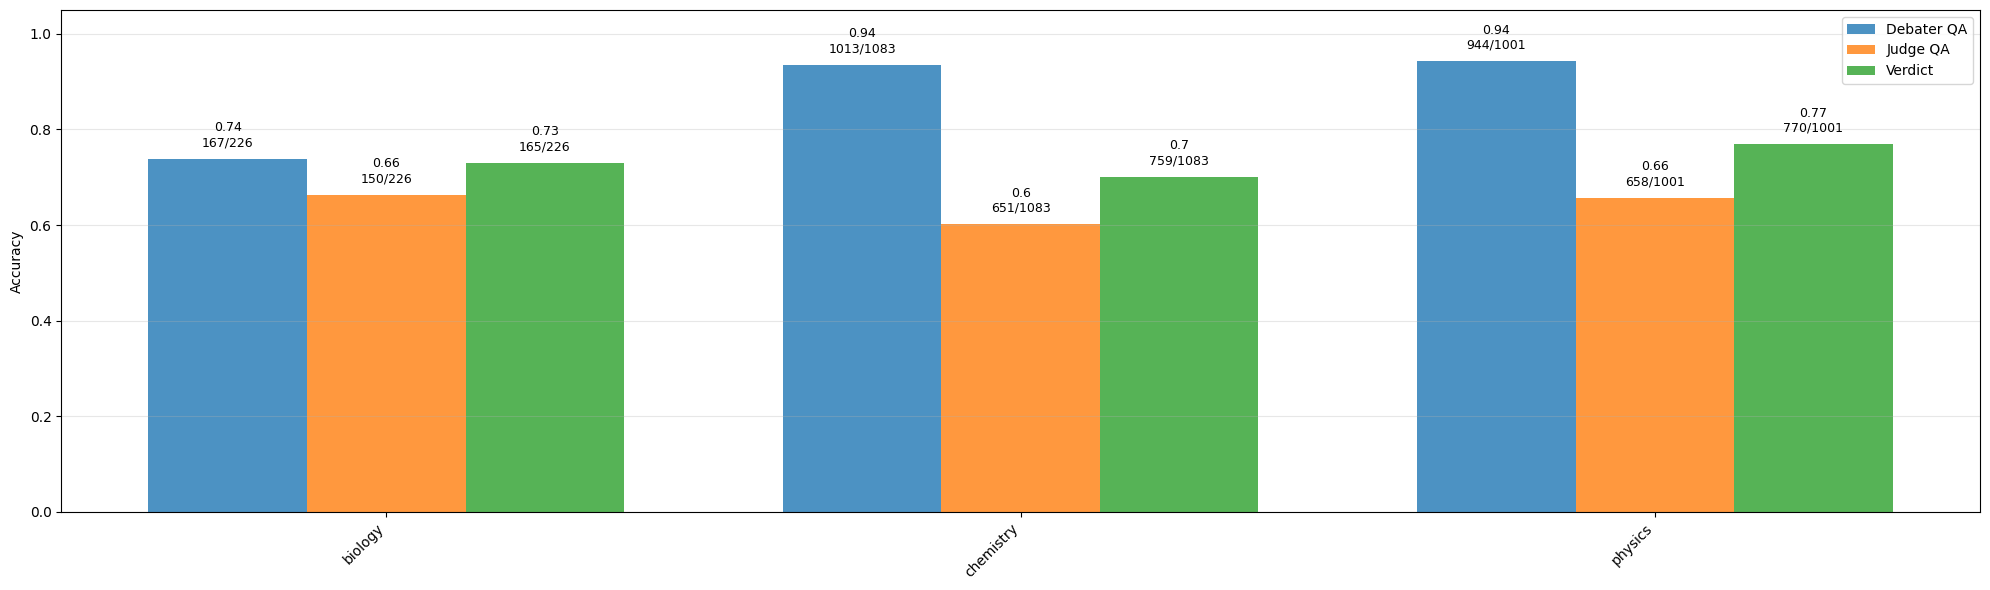

In [398]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['high_level_domain'])
aggregate_acc

from plot_utils import *
plot_results_by_name(aggregate_acc, field=None, plot_gap_and_gain=False)
plt.show()

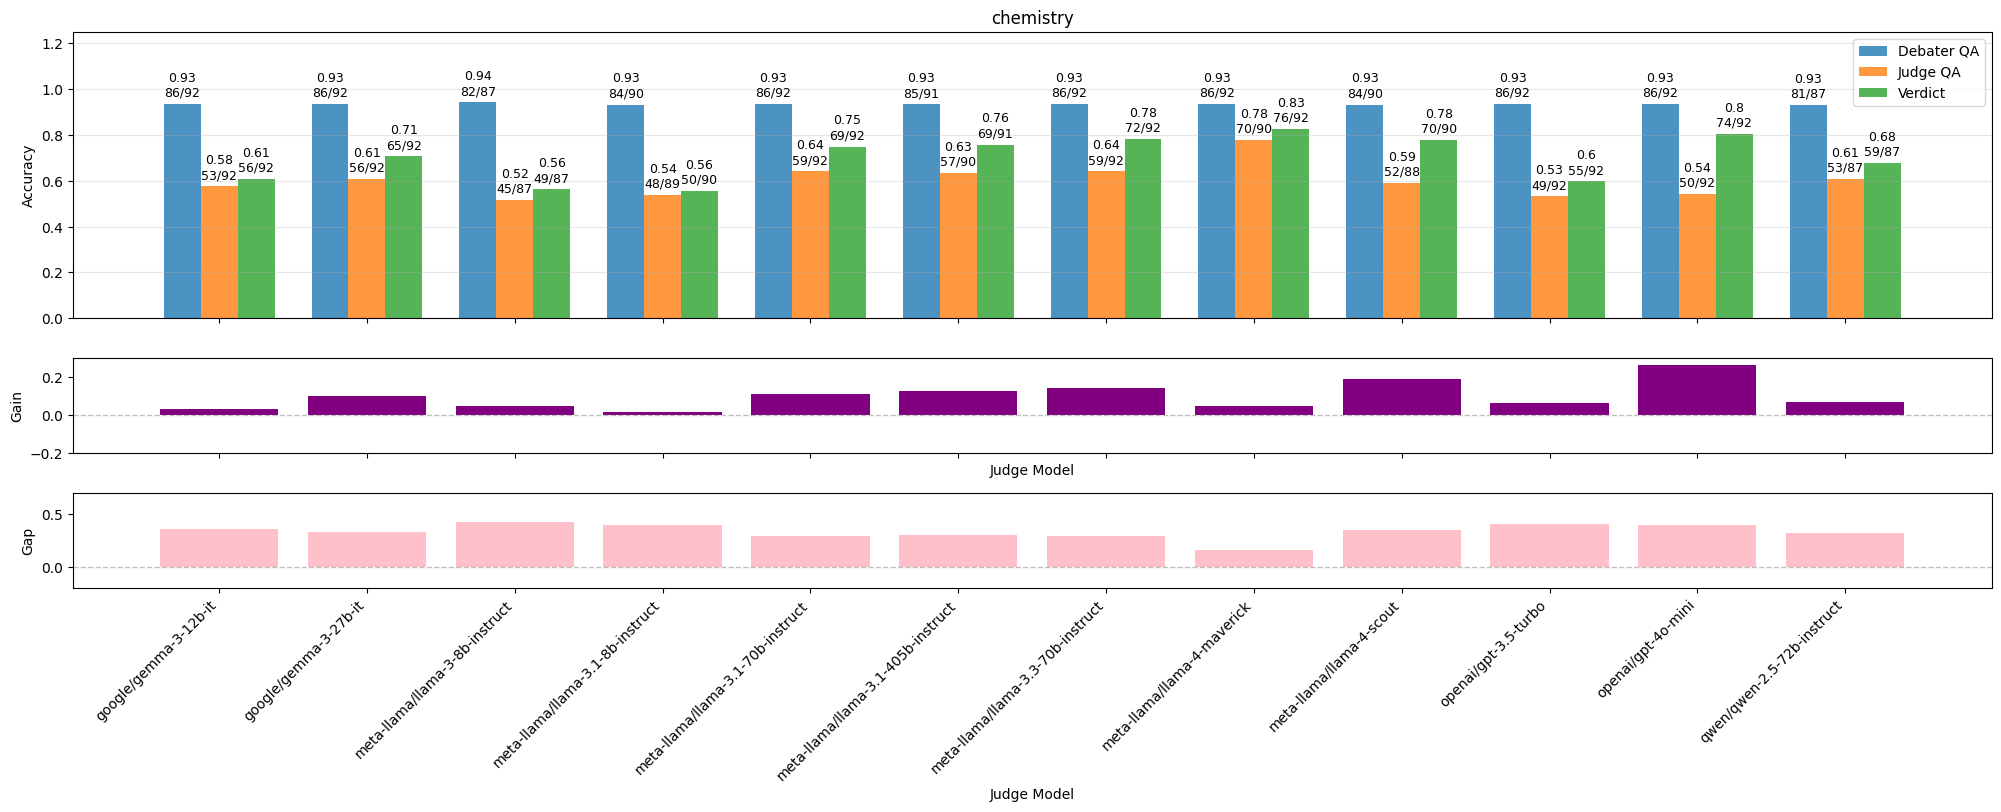

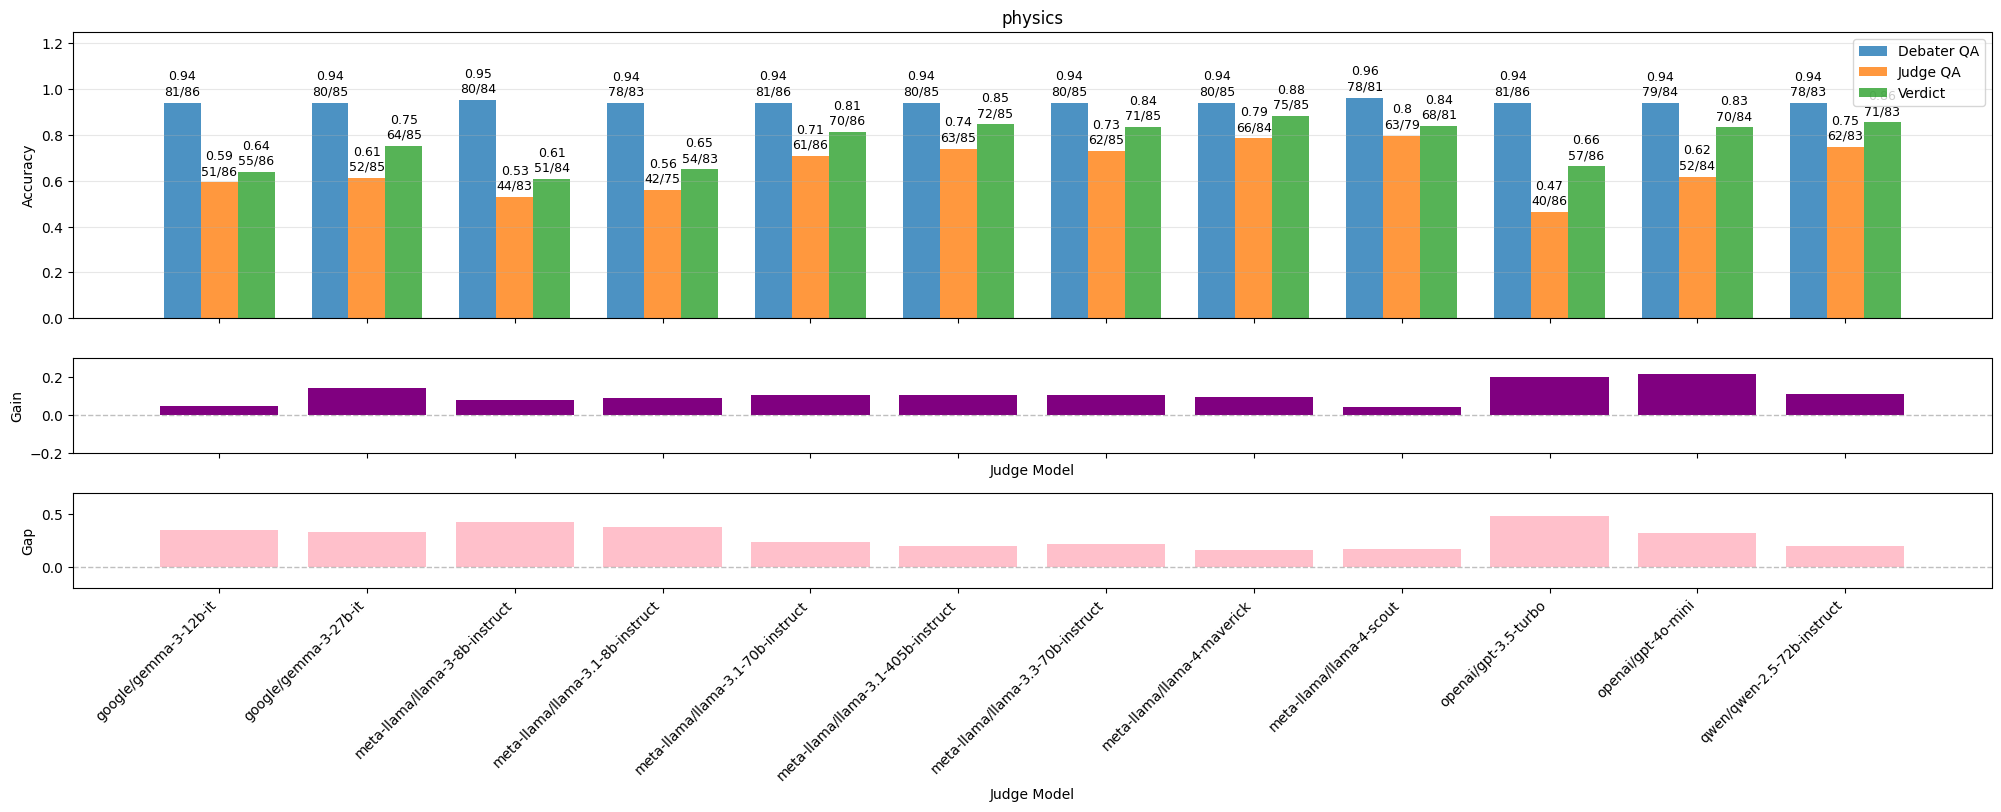

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: invalid value encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


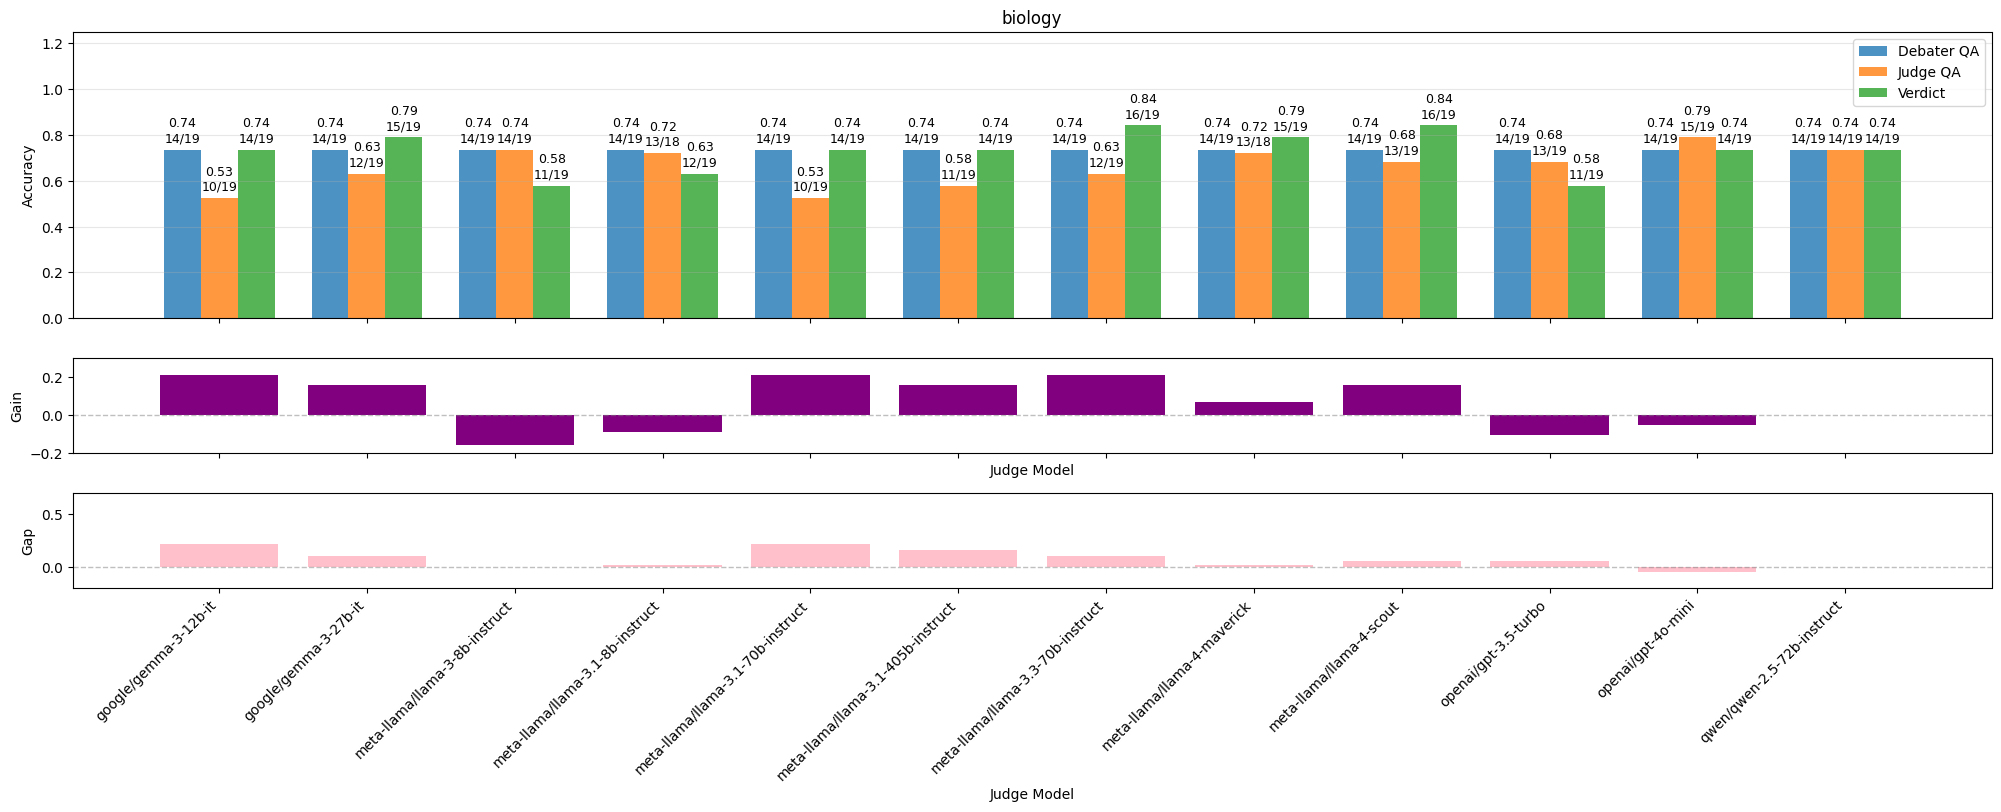

In [400]:
for field in verdicts_df['high_level_domain'].unique():
    field_df = verdicts_df[verdicts_df['high_level_domain'] == field]
    field_acc = aggregate_by_fields(field_df, ['config_judge_model_verdicts'])

    ax_acc, ax_gain, ax_gap = plot_results_by_name(field_acc)
    ax_acc.set_title(f'{field}')

    ax_gain.set_ylim([-.2, .3])
    ax_gap.set_ylim([-.2, .7])
    plt.show()

meta-llama/llama-3-8b-instruct


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


AttributeError: 'Axes' object has no attribute 'show'

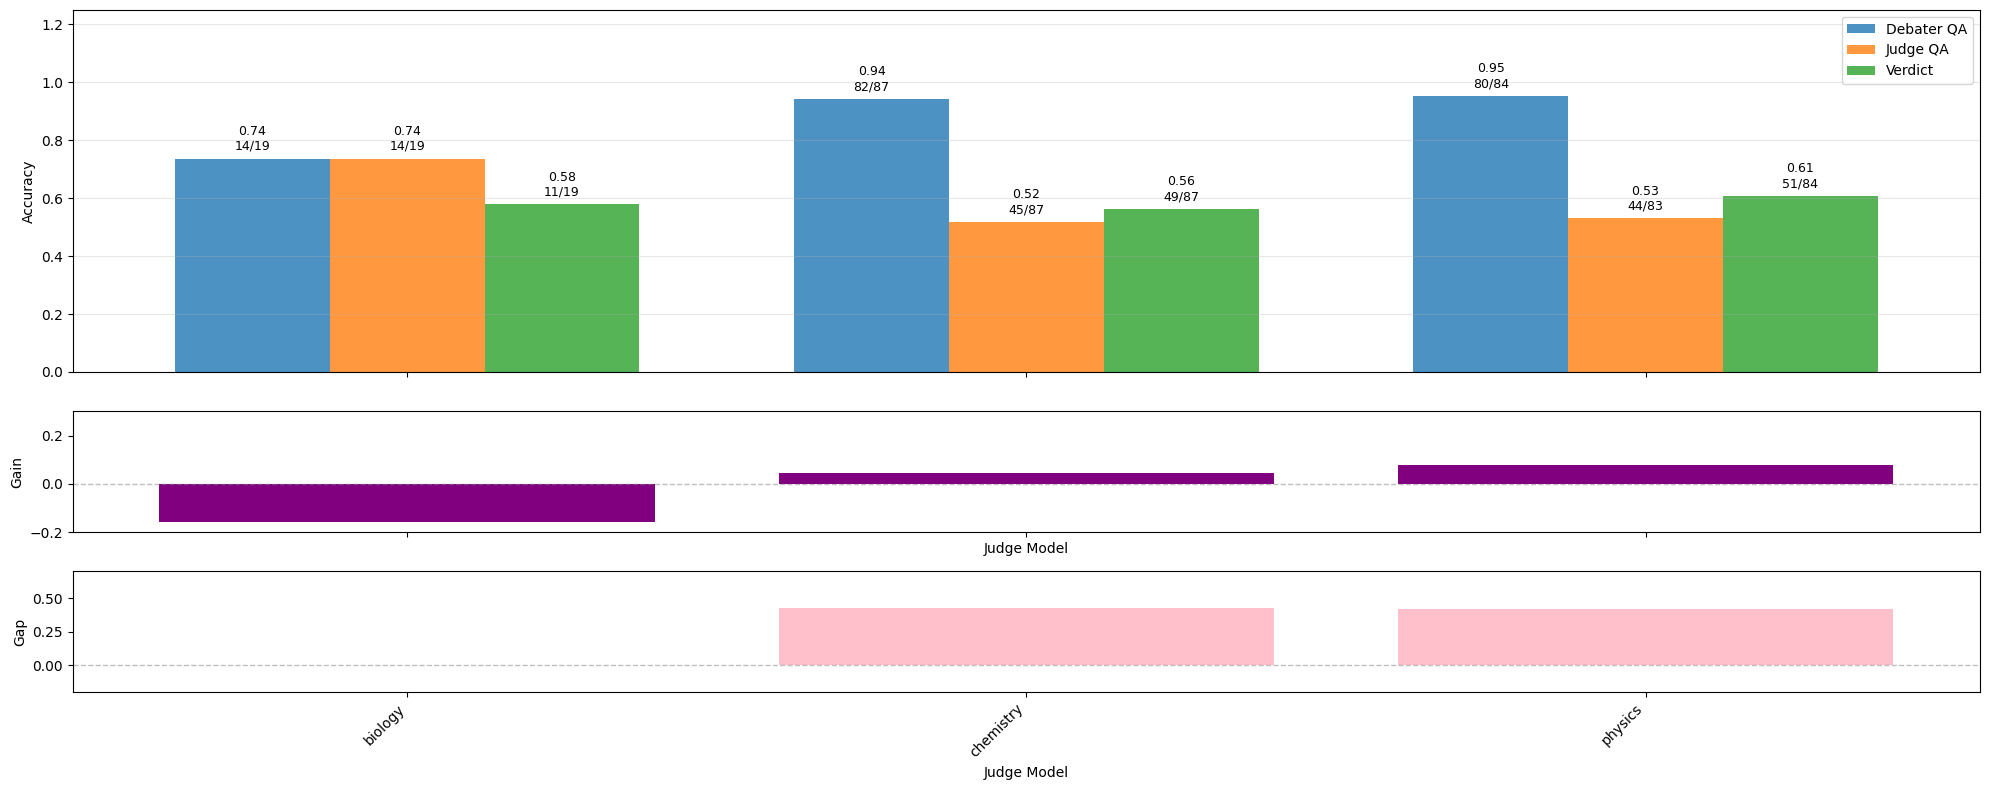

In [401]:
for model_name in verdicts_df['config_judge_model_verdicts'].unique():
    print(model_name)
    model_df = verdicts_df[verdicts_df['config_judge_model_verdicts'] == model_name]
    model_acc = aggregate_by_fields(model_df, ['high_level_domain'])

    plt, ax_gain, ax_gap = plot_results_by_name(model_acc, field=None)

    ax_gain.set_ylim([-.2, .3])
    ax_gap.set_ylim([-.2, .7])
    plt.show()

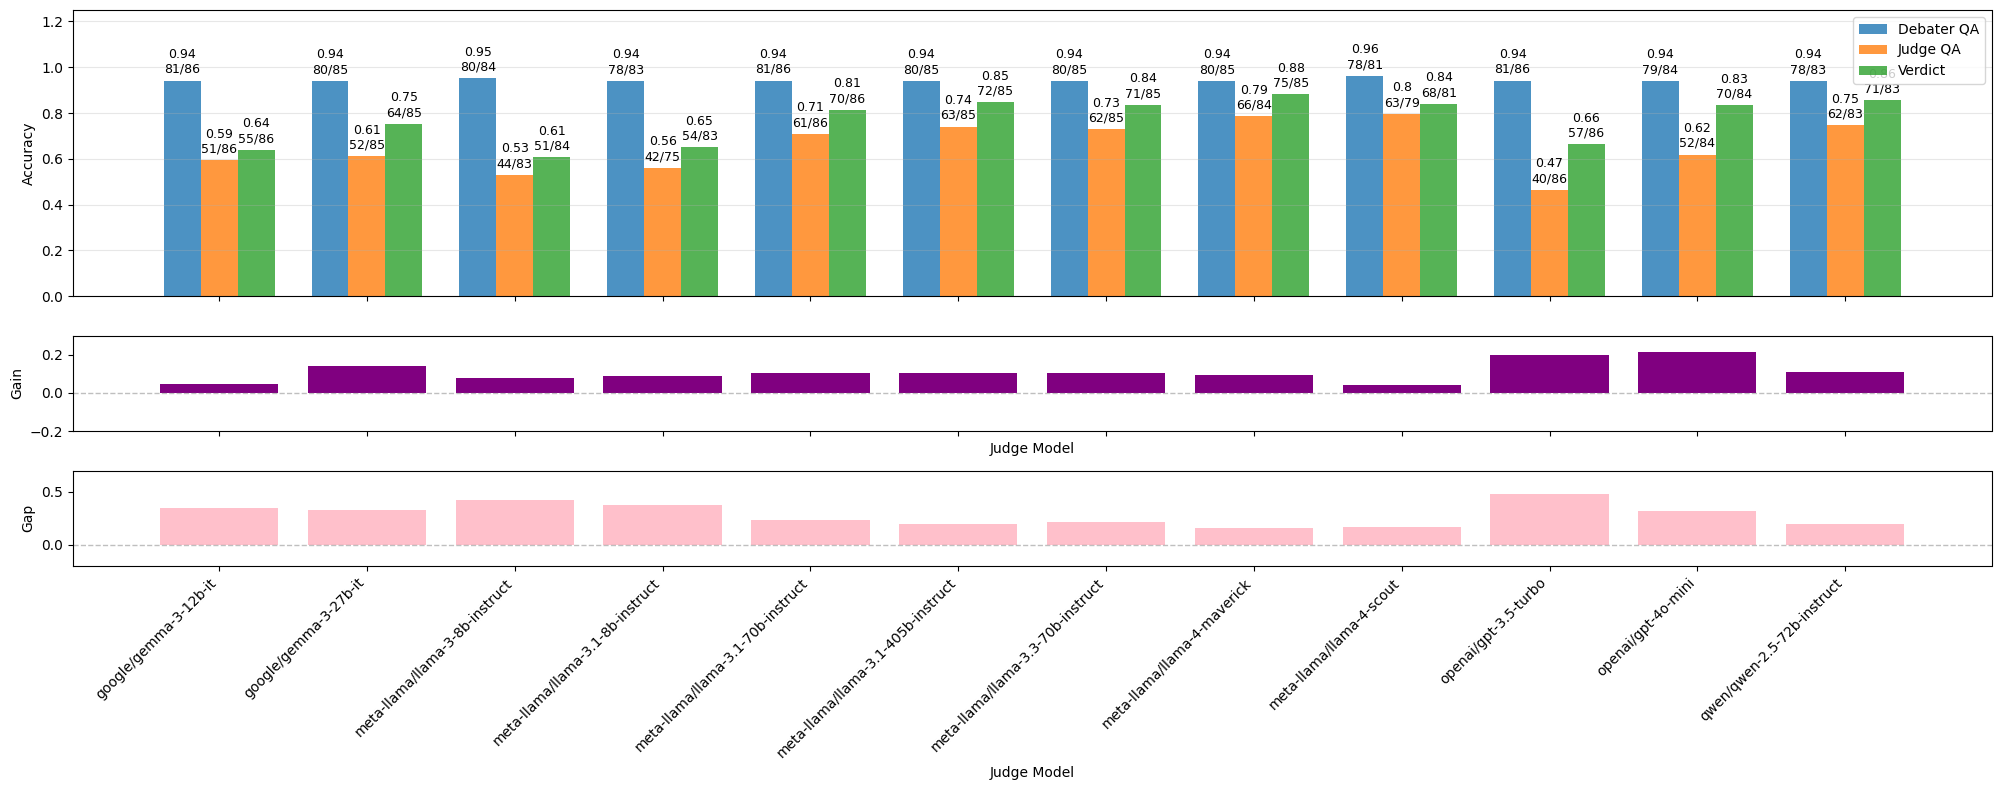

In [190]:
plt, ax_gain, ax_gap = plot_results_by_name(physics_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

In [193]:
physics_acc['gain'].mean(), chemistry_acc['gain'].mean()
# physics_acc['gain'].median(), chemistry_acc['gain'].median()



(np.float64(0.1108999244769499), np.float64(0.09981502260383888))

### By Difficulty

In [ ]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)
dataset_df['high_level_domain'] = dataset_df['high_level_domain'].str.lower()
verdicts_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))

In [404]:
dataset_df[["Writer's Difficulty Estimate", 'Question Difficulty_EV_1', 'Question Difficulty_EV_2']]

,Writer's Difficulty Estimate,Question Difficulty_EV_1,Question Difficulty_EV_2
0,Hard undergraduate level (could be a question ...,Easy undergraduate level (or easier),Hard undergraduate level (could be a question ...
1,Hard graduate level (could be a question on a ...,Hard undergraduate level (could be a question ...,Hard graduate level (could be a question on a ...
2,Hard undergraduate level (could be a question ...,Easy undergraduate level (or easier),Hard undergraduate level (could be a question ...
3,Hard undergraduate level (could be a question ...,Easy undergraduate level (or easier),Hard undergraduate level (could be a question ...
4,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...
...,...,...,...
193,Post-graduate level or harder (only individual...,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...
194,Hard graduate level (could be a question on a ...,Hard undergraduate level (could be a question ...,Hard graduate level (could be a question on a ...
195,Hard graduate level (could be a question on a ...,Hard graduate level (could be a question on a ...,Hard graduate level (could be a question on a ...
196,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...,Hard undergraduate level (could be a question ...


In [405]:
dataset_df["Writer's Difficulty Estimate"].value_counts()

Writer's Difficulty Estimate
Hard undergraduate level (could be a question on a hard undergraduate exam for students majoring in the subject)               118
Hard graduate level (could be a question on a hard graduate exam for PhD students in the domain)                                61
Post-graduate level or harder (only individuals with years of highly specialized expertise could reliably answer correctly)     12
Easy undergraduate level (or easier)                                                                                             3
Name: count, dtype: int64

In [409]:
dataset_df['Question Difficulty_EV_1'].value_counts()

Question Difficulty_EV_1
Hard undergraduate level (could be a question on a hard undergraduate exam for students majoring in the subject)               101
Hard graduate level (could be a question on a hard graduate exam for PhD students in the domain)                                43
Easy undergraduate level (or easier)                                                                                            40
Post-graduate level or harder (only individuals with years of highly specialized expertise could reliably answer correctly)      9
Name: count, dtype: int64

In [408]:
dataset_df['Question Difficulty_EV_2'].value_counts()

Question Difficulty_EV_2
Hard undergraduate level (could be a question on a hard undergraduate exam for students majoring in the subject)               105
Hard graduate level (could be a question on a hard graduate exam for PhD students in the domain)                                57
Easy undergraduate level (or easier)                                                                                            27
Post-graduate level or harder (only individuals with years of highly specialized expertise could reliably answer correctly)      7
Name: count, dtype: int64